# Human Detection Training with YOLOv11

## Imports

In [3]:
import kagglehub
import shutil
from ultralytics import YOLO
import torch
from pathlib import Path
from IPython.display import Image, display
import yaml
import pandas as pd
import numpy as np
import time

/mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/venv/lib64/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check CUDA

In [10]:
# Check CUDA availability

if cuda_available:= torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if cuda_available else 'cpu'
print(f"CUDA Available: {cuda_available}")

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Available: True


## Data Prepreration

### Download Dataset

In [3]:
kaggle_dataset_path = kagglehub.dataset_download("hillsworld/human-detection-yolo")

src = Path(kaggle_dataset_path) / "Final Dataset(2)"
dst = Path("../../datasets/human_detection")

dst.mkdir(parents=True, exist_ok=True)  # ensure target exists
for item in src.iterdir():
    shutil.move(str(item), str(dst))

### Setup Paths and Configuration

In [5]:
# Dataset configuration
dataset_dir = Path('../../datasets/human_detection')
data_yaml = dataset_dir / 'data.yaml'

# Verify paths exist
print(f"Dataset directory exists: {dataset_dir.exists()}")
print(f"Data YAML exists: {data_yaml.exists()}")

# Modify the yaml file 
with open(data_yaml, "r") as f:
    data = yaml.safe_load(f)

data["train"] = "./train/images"
data["val"] = "./valid/images"
data["test"] = "./test/images"

with open(data_yaml, "w") as f:
    yaml.dump(data, f)

Dataset directory exists: True
Data YAML exists: True


## Training

### Load YOLO11n Base Model

In [6]:
# Model configuration
model_name = 'yolo11n.pt'
project_name = '../../runs'
experiment_name = 'human_detection'

print(f"Project: {project_name}/{experiment_name}")

model = YOLO(model_name)

print(f"Model loaded: {model_name}")
print(f"Model type: {type(model)}")

Project: ../../runs/human_detection
Model loaded: yolo11n.pt
Model type: <class 'ultralytics.models.yolo.model.YOLO'>


### Fine-tuning YOLO11n base model

In [ ]:
print("Starting training...")

results = model.train(
    data=str(data_yaml),  # Path to the training data YAML file
    epochs=100,  # Increased epochs for better convergence
    batch=16,  # REDUCED: 16→8 to prevent OOM errors
    imgsz=640,
    seed=42,  # Random seed for reproducibility
    optimizer='AdamW',  # AdamW generally performs better than NAdam for YOLO
    weight_decay=0.0005,  # Reduced weight decay to allow better fitting
    momentum=0.937,  # Keep momentum
    cos_lr=True,  # Use cosine learning rate scheduling
    lr0=0.01,  # Increased initial learning rate for faster convergence
    lrf=0.001,  # Higher final learning rate to continue learning
    warmup_epochs=5,  # Reduced warmup epochs
    warmup_momentum=0.8,  # Higher warmup momentum
    warmup_bias_lr=0.1,  # Add warmup for bias learning rate
    close_mosaic=15,  # Keep mosaic longer - critical for occlusion training
    
    # Loss function tuning for overlapping detection
    label_smoothing=0.0,  # Disable for better precision on occluded objects
    dropout=0.0,  # Disable dropout to reduce regularization
    box=7.5,  # Box loss gain - default
    cls=0.5,  # Class loss gain - default  
    dfl=1.5,  # DFL loss gain - helps with precise localization
    
    # CRITICAL: Augmentations for occlusion/crowded scenes
    hsv_h=0.015,  # Color augmentation
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=5.0,  # Slight rotation for varied poses
    translate=0.2,  # More translation to simulate crowding
    scale=0.9,  # More scale variation for different person sizes
    shear=0.0,  # No shear
    perspective=0.0,  # No perspective
    flipud=0.0,  # No vertical flip
    fliplr=0.5,  # Horizontal flip
    
    # KEY AUGMENTATIONS FOR OCCLUSION (memory-optimized)
    mosaic=0.8,  # REDUCED: 1.0→0.8 (mosaic uses more memory)
    mixup=0.1,  # REDUCED: 0.15→0.1 to save memory
    copy_paste=0.2,  # REDUCED: 0.3→0.2 to save memory
    
    # NMS parameters for handling overlapping detections
    iou=0.7,  # IoU threshold for NMS training
    
    # Confidence and detection parameters
    conf=0.001,  # Lower confidence during training to learn difficult cases
    
    verbose=True,  # Print verbose training information
    project=project_name,  # Project name for organizing runs
    name=experiment_name,  # Experiment name
    exist_ok=True,  # Overwrite existing project/name
    pretrained=True,  # Use pretrained weights
    save=True,  # Save checkpoints
    save_period=10,  # Save checkpoint every N epochs
    device=device,  # Use GPU if available
    workers=2,  # Keep at 2 for lower memory usage
    amp=True,  # KEEP: AMP reduces memory usage
    cache=False,  # KEEP: Don't cache to save memory
    
    # Additional memory-saving parameters
    fraction=1.0  # Use full dataset
)

print("\nTraining completed!")

Starting training...
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.235 🚀 Python-3.14.0 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5804MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=0.001, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=../../datasets/Human_Detection/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=human

### Training Curves and Confusion Matrix

Results saved to: ../../runs/human_detection

Training Results:


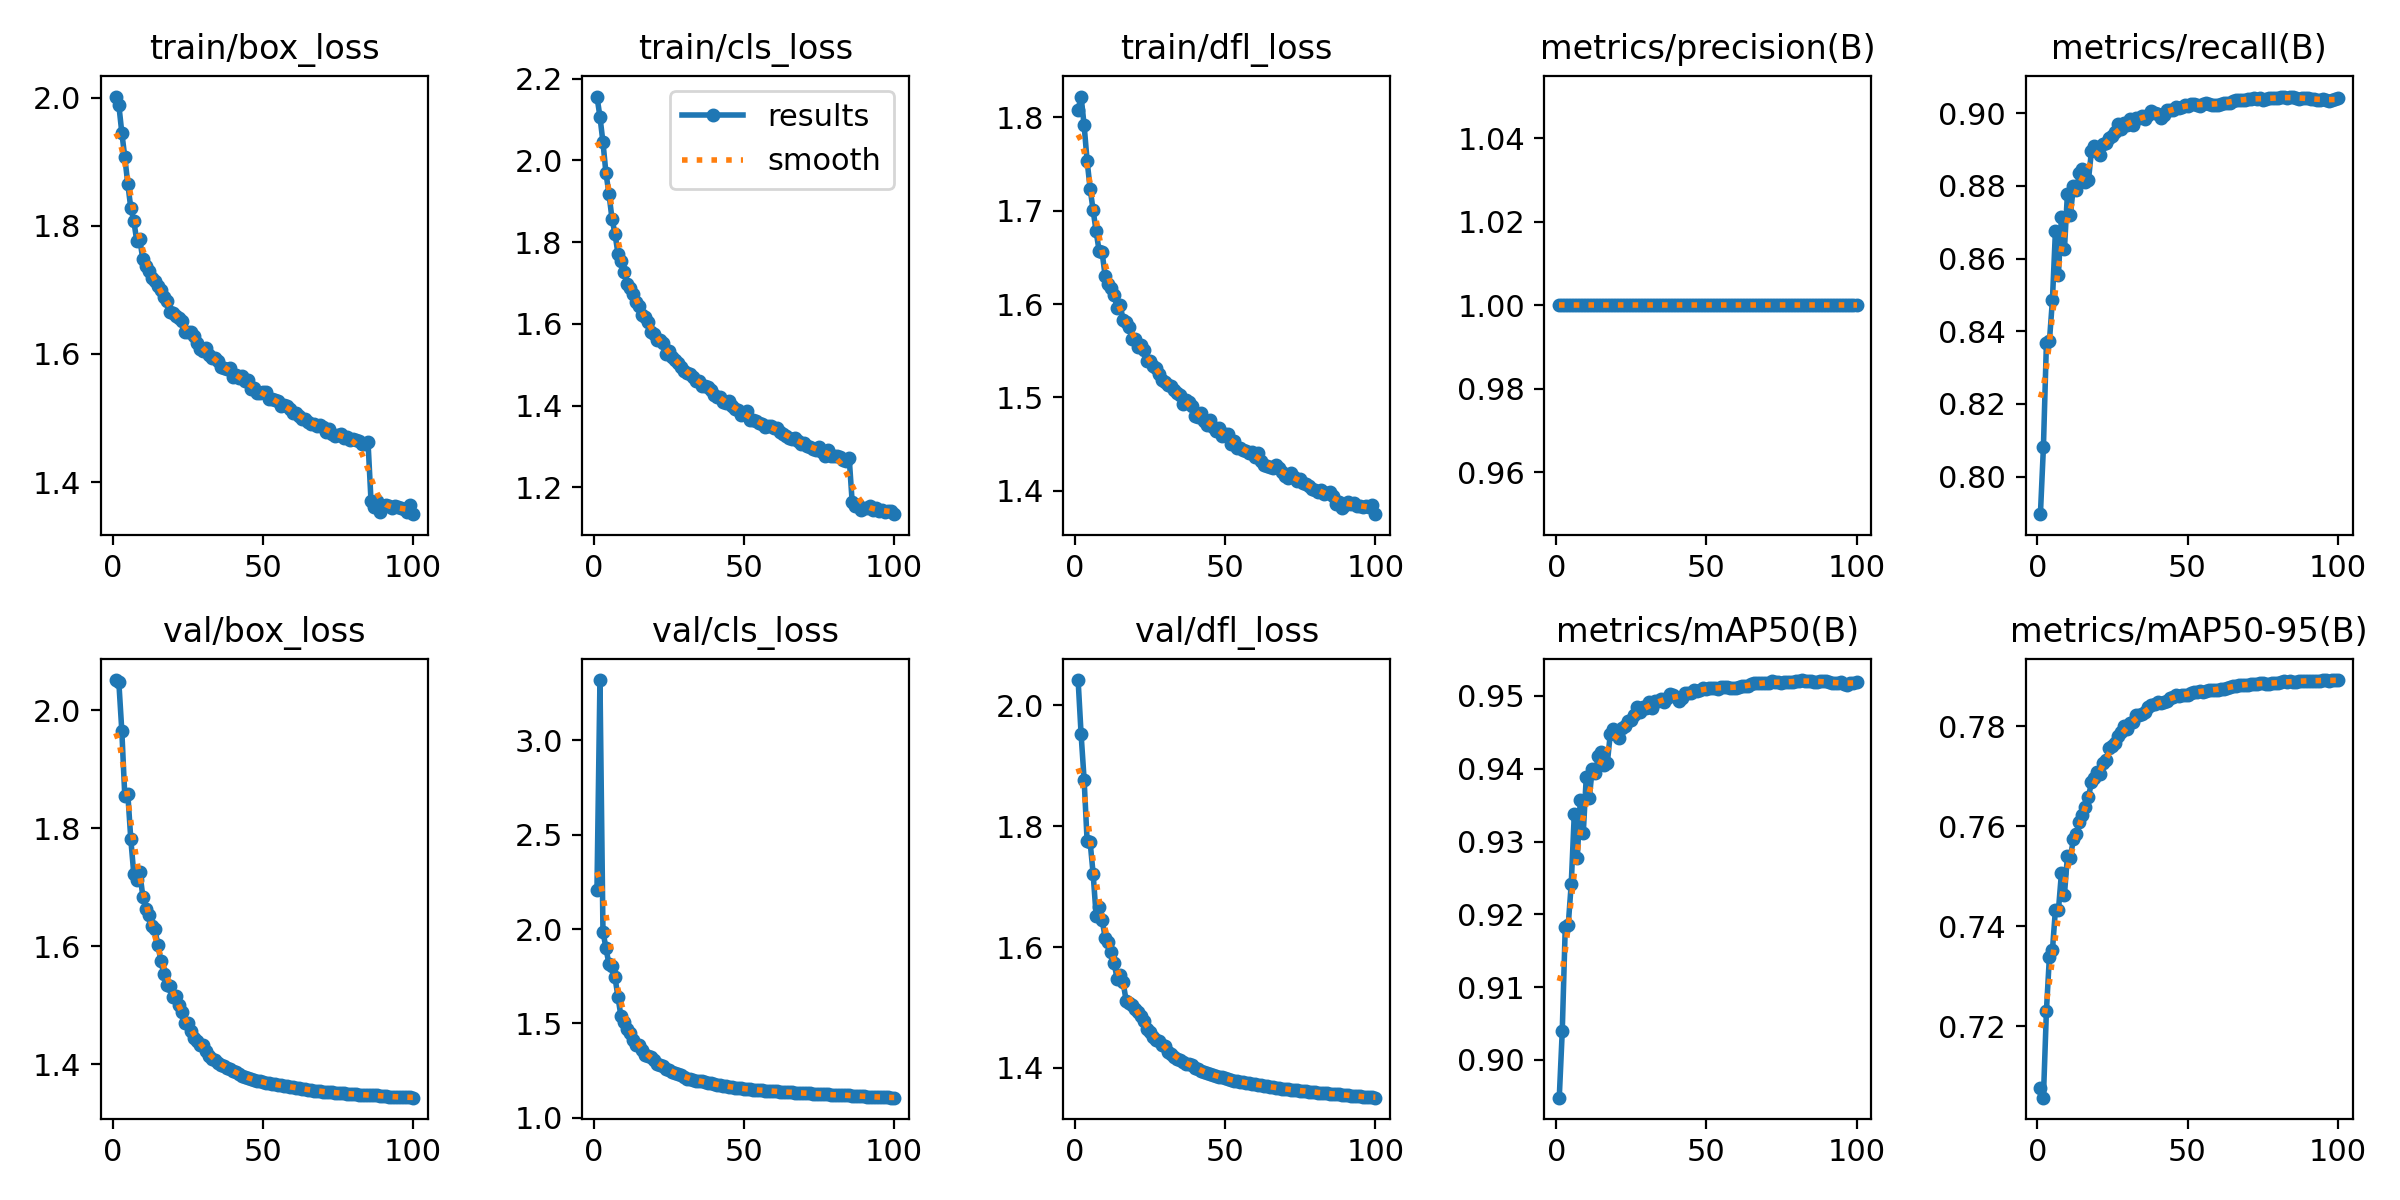


Confusion Matrix:


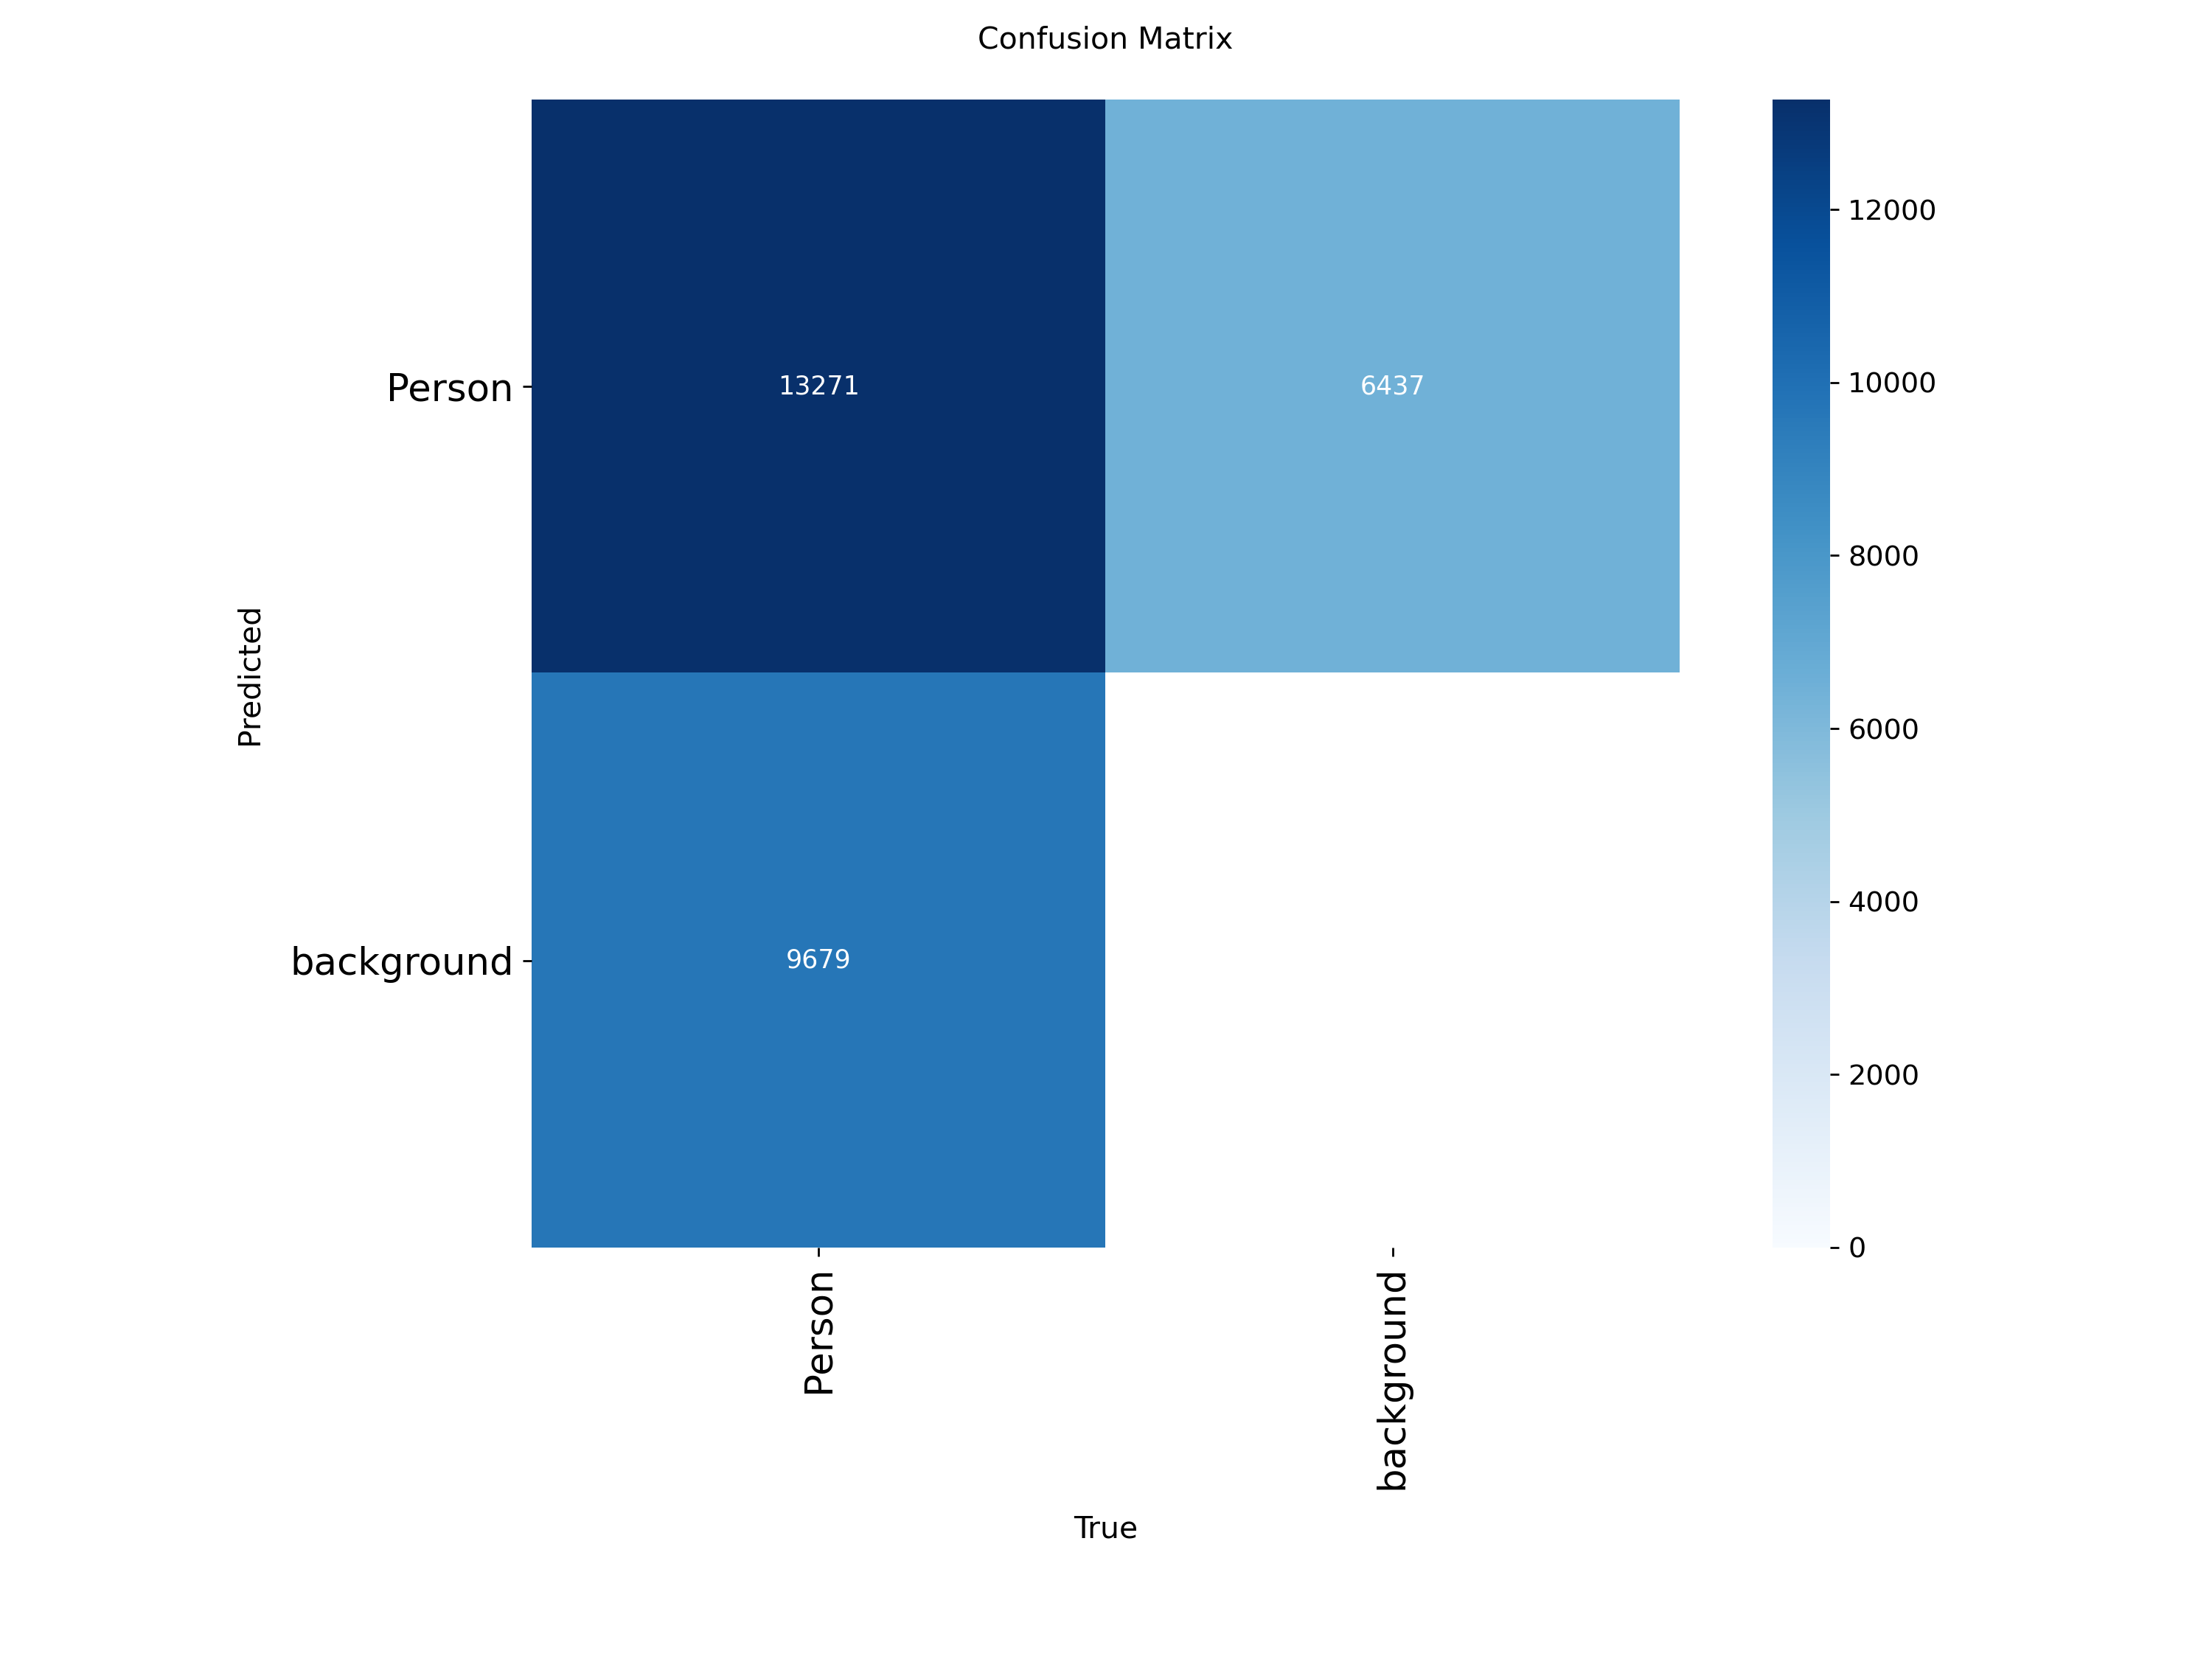

In [7]:
# Get the results directory
results_dir = Path(f'{project_name}/{experiment_name}')

print(f"Results saved to: {results_dir}")

# Display training curves
results_img = results_dir / 'results.png'
if results_img.exists():
    print("\nTraining Results:")
    display(Image(filename=str(results_img)))
else:
    print("Results image not found")

# Display confusion matrix
confusion_matrix = results_dir / 'confusion_matrix.png'
if confusion_matrix.exists():
    print("\nConfusion Matrix:")
    display(Image(filename=str(confusion_matrix)))

## Testing and Validation

### Load the trained model

In [8]:
best_model_path = results_dir / 'weights' / 'best.pt'
last_model_path = results_dir / 'weights' / 'last.pt'

if best_model_path.exists():
    model_best = YOLO(str(best_model_path))
    print(f"Loaded best model from: {best_model_path}")
else:
    print("Best model not found, using last model")
    model_best = YOLO(str(last_model_path))

# Set validation parameters
validation_parameters = {
    "data": str(data_yaml),
    "batch": 16,
    "imgsz": 640,
    "conf":0.001,
    "iou":0.7,
}

Loaded best model from: ../../runs/human_detection/weights/best.pt


### Testing

Running predictions on 5 test images from ../../datasets/human_detection/test/images

0: 640x640 5 Persons, 12.3ms
1: 640x640 2 Persons, 12.3ms
2: 640x640 5 Persons, 12.3ms
3: 640x640 5 Persons, 12.3ms
4: 640x640 7 Persons, 12.3ms
Speed: 3.9ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/predictions/human_detection

Predictions saved to: ../../predictions/human_detection

Sample prediction:


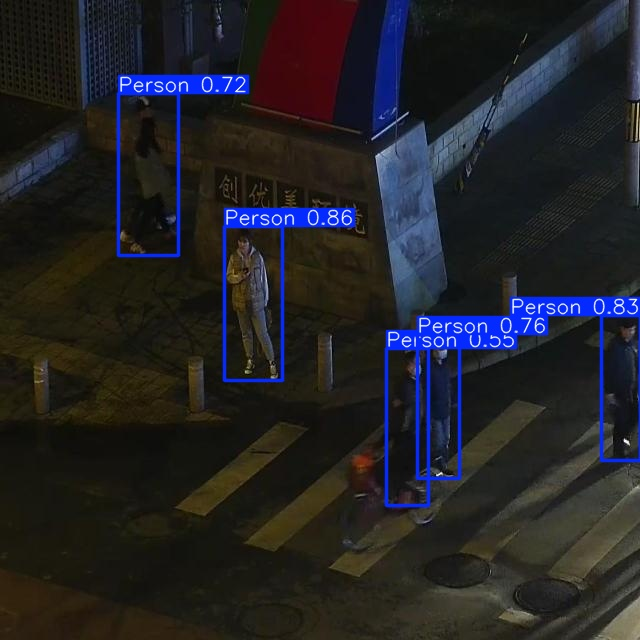


Test Metrics
../../runs/human_detection


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
99,100.0,30970.2,1.35003,1.13449,1.37478,1.0,0.9041,0.95192,0.78921,1.34347,1.10633,1.35079,0.000012,0.000012,0.000012


In [9]:
test_images_dir = dataset_dir / 'test' / 'images'
test_image_count = 5
test_images = list(test_images_dir.glob('*.jpg'))[:test_image_count]

prediction_project = Path('../../predictions')

if test_images:
    print(f"Running predictions on {test_image_count} test images from {str(test_images_dir)}")

    predictions = model_best.predict(
        source=test_images,
        imgsz=640,
        conf=0.25,
        iou=0.45,
        save=True,
        project=str(prediction_project),
        name=experiment_name,
        exist_ok=True,
        max_det=300,
        agnostic_nms=False
    )

    pred_dir = prediction_project / experiment_name
    print(f"\nPredictions saved to: {pred_dir}")

    # Display first prediction
    pred_images = list(pred_dir.glob('*.jpg'))
    if pred_images:
        print("\nSample prediction:")
        display(Image(filename=str(pred_images[0])))

    # -----------------------------
    #       LOAD TEST METRICS
    # -----------------------------
    print("\nTest Metrics")

    results_csv = results_dir / "results.csv"
    print(results_dir)

    df = pd.read_csv(results_csv)

    # Last row
    last = df.iloc[-1]

    # Display as a proper table
    display(pd.DataFrame([last]))
else:
    print("No test images found")

### Baseline vs Fine-tuned Models Comparison

In [10]:
# Load validation images
with open(data_yaml, 'r') as f:
    data_config = yaml.safe_load(f)

val_path = dataset_dir / data_config['val']
val_images = list(Path(val_path).glob('*.jpg'))

if len(val_images) == 0:
    val_path = Path(data_config['val'])
    val_images = list(Path(val_path).glob('*.jpg'))

print(f"✓ Found {len(val_images)} validation images")

print("Loading pretrained YOLO11n model...\n")
baseline_model = YOLO('yolo11n.pt')
print("Pretrained YOLO11n loaded successfully.\n")


# Run validation on baseline model
print("Running validation on baseline model...")
baseline_val_results = baseline_model.val(
    data=validation_parameters.get('data'),
    batch=validation_parameters.get('batch'),
    imgsz=validation_parameters.get('imgsz'),
    conf=validation_parameters.get('conf'),
    iou=validation_parameters.get('iou'),
    device=device,
    plots=True,
    save_json=True,
    verbose=True,
    project=str(Path(project_name) / 'human_detection'),
    name='baseline_yolo11n_metrics'
)

# Extract baseline metrics
baseline_precision = baseline_val_results.box.mp
baseline_recall = baseline_val_results.box.mr
baseline_mAP50 = baseline_val_results.box.map50
baseline_mAP50_95 = baseline_val_results.box.map

# Load fine-tuned model
print("Loading fine-tuned model...\n")
finetuned_model = model_best
print(f"Loaded fine-tuned model from: {best_model_path}")

# Run validation on fine-tuned model
print("\nRunning validation on fine-tuned model...")
finetuned_val_results = finetuned_model.val(
    data=validation_parameters.get('data'),
    batch=validation_parameters.get('batch'),
    imgsz=validation_parameters.get('imgsz'),
    conf=validation_parameters.get('conf'),
    iou=validation_parameters.get('iou'),
    device=device,
    plots=True,
    save_json=True,
    verbose=True,
    project=str(Path(project_name) / 'human_detection'),
    name='finetuned_yolo11n_metrics'
)

# Extract fine-tuned metrics
finetuned_precision = finetuned_val_results.box.mp
finetuned_recall = finetuned_val_results.box.mr
finetuned_mAP50 = finetuned_val_results.box.map50
finetuned_mAP50_95 = finetuned_val_results.box.map

# Measure inference time on random sample
num_test_images = min(100, len(val_images))
test_images = np.random.choice(val_images, num_test_images, replace=False)

print(f"\nMeasuring inference time on {num_test_images} images...")

print("\nTesting baseline model...")
_ = baseline_model.predict(test_images[0], verbose=False, imgsz=validation_parameters.get('imgsz'))  # Warm-up

baseline_inference_times = []
for img_path in test_images:
    start_time = time.time()
    _ = baseline_model.predict(img_path, verbose=False, 
                               imgsz=validation_parameters.get('imgsz'), 
                               conf=validation_parameters.get('conf'), 
                               iou=validation_parameters.get('iou'))
    end_time = time.time()
    baseline_inference_times.append((end_time - start_time) * 1000)

baseline_avg_time = np.mean(baseline_inference_times)
baseline_std_time = np.std(baseline_inference_times)

print("\nTesting fine-tuned model...")
_ = finetuned_model.predict(test_images[0], verbose=False, imgsz=validation_parameters.get('imgsz'))  # Warm-up

finetuned_inference_times = []
for img_path in test_images:
    start_time = time.time()
    _ = finetuned_model.predict(img_path, verbose=False, 
                                imgsz=validation_parameters.get('imgsz'), 
                                conf=validation_parameters.get('conf'), 
                                iou=validation_parameters.get('iou'))
    end_time = time.time()
    finetuned_inference_times.append((end_time - start_time) * 1000)

finetuned_avg_time = np.mean(finetuned_inference_times)
finetuned_std_time = np.std(finetuned_inference_times)

# F1-Scores
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall + 1e-6)
finetuned_f1 = 2 * (finetuned_precision * finetuned_recall) / (finetuned_precision + finetuned_recall + 1e-6)

print("\n" + "="*70)
print("COMPARISON TABLE")
print("="*70)

# Calculate improvements
map50_improvement = ((finetuned_mAP50 - baseline_mAP50) / baseline_mAP50) * 100
mAP50_95_improvement = ((finetuned_mAP50_95 - baseline_mAP50_95) / baseline_mAP50_95) * 100
precision_improvement = ((finetuned_precision - baseline_precision) / baseline_precision) * 100
recall_improvement = ((finetuned_recall - baseline_recall) / baseline_recall) * 100
time_diff = finetuned_avg_time - baseline_avg_time
f1_improvement = ((finetuned_f1 - baseline_f1) / baseline_f1) * 100

# Create comparison table
comparison_table = pd.DataFrame({
    'Model': ['Baseline (YOLO11n)', 'Ours (Fine-tuned)', 'Improvement'],
    'mAP@0.5': [
        f'{baseline_mAP50:.2%}',
        f'{finetuned_mAP50:.2%}',
        f'{map50_improvement:+.1f}%'
    ],
    'mAP50_95': [
        f'{baseline_mAP50_95:.2%}',
        f'{finetuned_mAP50_95:.2%}',
        f'{mAP50_95_improvement:+.1f}%'
    ],
    'Precision': [
        f'{baseline_precision:.4f}',
        f'{finetuned_precision:.4f}',
        f'{precision_improvement:+.1f}%'
    ],
    'Recall': [
        f'{baseline_recall:.4f}',
        f'{finetuned_recall:.4f}',
        f'{recall_improvement:+.1f}%'
    ],
    'F1-Score': [
        f'{baseline_f1:.4f}',
        f'{finetuned_f1:.4f}',
        f'{f1_improvement:+.1f}%'
    ],
    'Inference Time (ms)': [
        f'{baseline_avg_time:.0f}',
        f'{finetuned_avg_time:.0f}',
        f'{time_diff:+.0f}'
    ]
})

display(comparison_table)

comparison_table_save_path = Path(project_name) / experiment_name / 'comparison_table.csv'
comparison_table.to_csv(comparison_table_save_path, index=False)
print(f"\nDetailed comparison saved to: {comparison_table_save_path}")
print("\nComparison done.")

✓ Found 6781 validation images
Loading pretrained YOLO11n model...

Pretrained YOLO11n loaded successfully.

Running validation on baseline model...
Ultralytics 8.3.235 🚀 Python-3.14.2 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5804MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 144.2±51.5 MB/s, size: 238.0 KB)
val: Scanning /mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/datasets/human_detection/valid/labels.cache... 6781 images, 481 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6781/6781 12.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 424/424 10.1it/s 42.0s<0.1s
                   all       6781      22950          1      0.828      0.914      0.766
                person       6300      22950          1      0.828      0.914      0.766
Speed: 0.6m

,Model,mAP@0.5,mAP50_95,Precision,Recall,F1-Score,Inference Time (ms)
0,Baseline (YOLO11n),91.42%,76.56%,1.0000,0.8284,0.9062,20
1,Ours (Fine-tuned),95.19%,78.92%,1.0000,0.9041,0.9496,15
2,Improvement,+4.1%,+3.1%,+0.0%,+9.1%,+4.8%,-5



Detailed comparison saved to: ../../runs/human_detection/comparison_table.csv

Comparison done.


## Retraining

In [12]:
rproject_name = '../../runs/human_detection'
rexperiment_name = 'retraining'

retrain_results = model_best.train(
    data=str(data_yaml),
    project=rproject_name,
    name=rexperiment_name,
    
    # Core retraining parameters
    epochs=50,              # Fewer epochs since model is already trained
    lr0=0.001,              # LOWER learning rate (was 0.01) - fine-tuning
    lrf=0.0001,             # Lower final LR (was 0.001)
    warmup_epochs=3,        # Shorter warmup (was 5)
    
    # Regularization (add more to prevent overfitting)
    weight_decay=0.001,     # INCREASE (was 0.0005) - more regularization
    dropout=0.1,            # ADD dropout (was 0.0) - prevent overfitting
    label_smoothing=0.05,   # ADD smoothing (was 0.0) - smoother predictions
    
    # Reduce aggressive augmentations
    mosaic=0.5,             # REDUCE (was 0.8) - less aggressive
    mixup=0.05,             # REDUCE (was 0.1)
    copy_paste=0.1,         # REDUCE (was 0.2)
    close_mosaic=10,        # EARLIER (was 15) - disable mosaic sooner
    
    # Keep these from original
    batch=16,
    optimizer='AdamW',
    cos_lr=True,
    device=device,
    workers=2,
    amp=True,
    pretrained=False,        # Or set to False if loading your trained weights
)

New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.235 🚀 Python-3.14.2 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5804MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=../../datasets/human_detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.05, mode

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 2.7it/s 1:17<0.2ss
                   all       6781      22950          1      0.888      0.944      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50       3.6G       1.43      1.275       1.42         23        640: 100% ━━━━━━━━━━━━ 1254/1254 5.5it/s 3:48<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.4s<23.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.7s<0.2s
                   all       6781      22950          1      0.907      0.954      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      4.18G      1.403      1.246      1.405         12        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 13.2s<23.8s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.0s<0.2s
                   all       6781      22950          1      0.905      0.952       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50       3.5G      1.399      1.235      1.398         39        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:01<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.7s<24.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.1s<0.2s
                   all       6781      22950          1      0.905      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      3.83G      1.396      1.235      1.396         25        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.5it/s 12.9s<25.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.6it/s 37.8s<0.2s
                   all       6781      22950          1      0.904      0.952       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      3.48G      1.391       1.22      1.397          9        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.6it/s 12.7s<24.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.8s<0.2s
                   all       6781      22950          1      0.904      0.952      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      3.02G      1.389      1.226       1.39         45        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.7s<23.1s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.0s<0.2s
                   all       6781      22950          1      0.904      0.952       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      2.91G      1.385      1.223      1.394         55        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.6s<24.3s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.2s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      3.52G      1.391       1.23      1.392         24        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.8s<24.0s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.7s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      3.45G      1.384      1.218      1.386         20        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.8s<24.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.2s<0.2s
                   all       6781      22950          1      0.904      0.952       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      3.51G      1.392      1.226      1.395         19        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.8s<23.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 36.9s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      2.64G      1.376      1.216      1.384         34        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.3s<23.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.8s<0.2s
                   all       6781      22950          1      0.906      0.953       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      3.54G      1.382      1.219       1.39         65        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.7s<23.3s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.0s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      3.45G      1.384      1.218      1.391         56        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:01<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.4s<23.0s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.0s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      3.52G      1.376      1.211      1.386         18        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.4s<23.8s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.1s<0.2s
                   all       6781      22950          1      0.906      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      3.55G      1.382       1.21      1.385          8        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.6s<23.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.4s<0.2s
                   all       6781      22950          1      0.906      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      3.44G      1.372      1.202      1.383         33        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:58<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.8s<23.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.1s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50         4G      1.378      1.211      1.383         29        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.9s<24.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.7it/s 37.5s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      3.45G       1.38      1.213      1.388         14        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 3:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.5s<23.6s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.3s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      2.92G       1.37      1.208      1.382         12        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.3s<23.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.7s<0.2s
                   all       6781      22950          1      0.906      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      3.14G      1.374      1.211      1.386         47        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.6s<23.3s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.7s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      3.13G      1.371      1.207       1.38         23        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.6it/s 12.6s<24.6s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.5s<0.2s
                   all       6781      22950          1      0.907      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      3.52G      1.373      1.201      1.382         18        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.4s<23.6s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.0s<0.2s
                   all       6781      22950          1      0.906      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      2.64G      1.381      1.208      1.388         61        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.5s<24.1s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.0s<0.2s
                   all       6781      22950          1      0.906      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      3.54G      1.372        1.2      1.379         28        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.6s<24.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.8s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      3.44G       1.37      1.204       1.38         33        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:03<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.5s<24.0s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.7s<0.2s
                   all       6781      22950          1      0.907      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      3.48G      1.373      1.204      1.379         17        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.4s<23.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.0s<0.2s
                   all       6781      22950          1      0.906      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50       3.1G      1.374      1.203      1.383         30        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:00<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.5s<23.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.5s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      3.45G      1.363       1.19      1.373         14        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:00<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.5s<23.2s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.6s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      2.91G       1.36      1.189      1.376         26        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.1s<24.3s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.7s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      3.53G      1.367      1.195      1.375         25        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.6it/s 12.5s<24.6s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.5s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      4.02G      1.364      1.191      1.373         12        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 3:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.2s<23.3s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 6.0it/s 35.6s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50       3.1G      1.367      1.198      1.374         17        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 3:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.3s<23.6s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.2s<0.2s
                   all       6781      22950          1      0.905      0.952      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      3.46G      1.363      1.189      1.378          8        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:02<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.2s<23.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.1s<0.2s
                   all       6781      22950          1      0.906      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      2.91G      1.359      1.191      1.377         74        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:56<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.7it/s 12.3s<24.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.8s<0.2s
                   all       6781      22950          1      0.905      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      2.64G       1.36      1.191      1.376         18        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:01<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.3s<23.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.3s<0.2s
                   all       6781      22950          1      0.905      0.952      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      2.66G      1.363      1.193      1.377         44        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.3s<23.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.6s<0.2s
                   all       6781      22950          1      0.905      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50         4G       1.36      1.189      1.373         35        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 4:01<0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.4s<23.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.5s<0.2s
                   all       6781      22950          1      0.906      0.953      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50       3.5G      1.363       1.19      1.377         33        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.4it/s 12.1s<21.8s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 6.0it/s 35.5s<0.2s
                   all       6781      22950          1      0.905      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50      3.47G      1.362      1.189      1.373         38        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.6s<23.6s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.8s<0.2s
                   all       6781      22950          1      0.905      0.953      0.791
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      3.52G      1.315      1.098      1.348         28        640: 100% ━━━━━━━━━━━━ 1254/1254 5.4it/s 3:52<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.0s<23.3s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.8s<0.2s
                   all       6781      22950          1      0.905      0.952      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      3.44G      1.317      1.098      1.349         30        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:58<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.2s<23.4s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.0s<0.2s
                   all       6781      22950          1      0.905      0.953      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      3.43G      1.312      1.095      1.347         13        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:56<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.3it/s 11.9s<22.1s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 6.0it/s 35.3s<0.1s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      3.41G      1.313      1.093      1.347         10        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:56<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.1it/s 12.5s<22.7s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.4s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      3.48G      1.316      1.095      1.348         28        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:58<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.4s<23.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.5s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50      3.52G      1.312      1.093      1.346         36        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 3:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.0it/s 12.5s<23.2s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.3s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      3.43G      1.311      1.095      1.346          5        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:58<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.2s<23.5s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 36.1s<0.2s
                   all       6781      22950          1      0.904      0.952      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      3.52G      1.313      1.095      1.348          9        640: 100% ━━━━━━━━━━━━ 1254/1254 5.2it/s 3:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.8it/s 12.4s<24.2s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.8s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      3.52G      1.312      1.092      1.346         27        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 6.1it/s 12.4s<22.9s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.8it/s 36.4s<0.2s
                   all       6781      22950          1      0.905      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      3.52G      1.313       1.09      1.346          9        640: 100% ━━━━━━━━━━━━ 1254/1254 5.3it/s 3:57<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 34% ━━━━──────── 73/212 5.9it/s 12.2s<23.7s

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 6.0it/s 35.5s<0.2s
                   all       6781      22950          1      0.904      0.952      0.791

50 epochs completed in 3.860 hours.
Optimizer stripped from /mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/runs/human_detection/retraining/weights/last.pt, 5.4MB
Optimizer stripped from /mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/runs/human_detection/retraining/weights/best.pt, 5.4MB

Validating /mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/runs/human_detection/retraining/weights/best.pt...
Ultralytics 8.3.235 🚀 Python-3.14.2 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5804MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
    

Corrupt JPEG data: 3543 extraneous bytes before marker 0xd9


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 212/212 5.9it/s 35.9s<0.2s
                   all       6781      22950          1      0.907      0.953      0.792
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /mnt/41A664F31125B500/Personal/Academics/4th_Year/1st_Sem/CSC173_Intelligent_Systems/CSC173-DeepCV-Bautista/runs/human_detection/retraining


Results saved to: ../../runs/human_detection/retraining

Training Results:


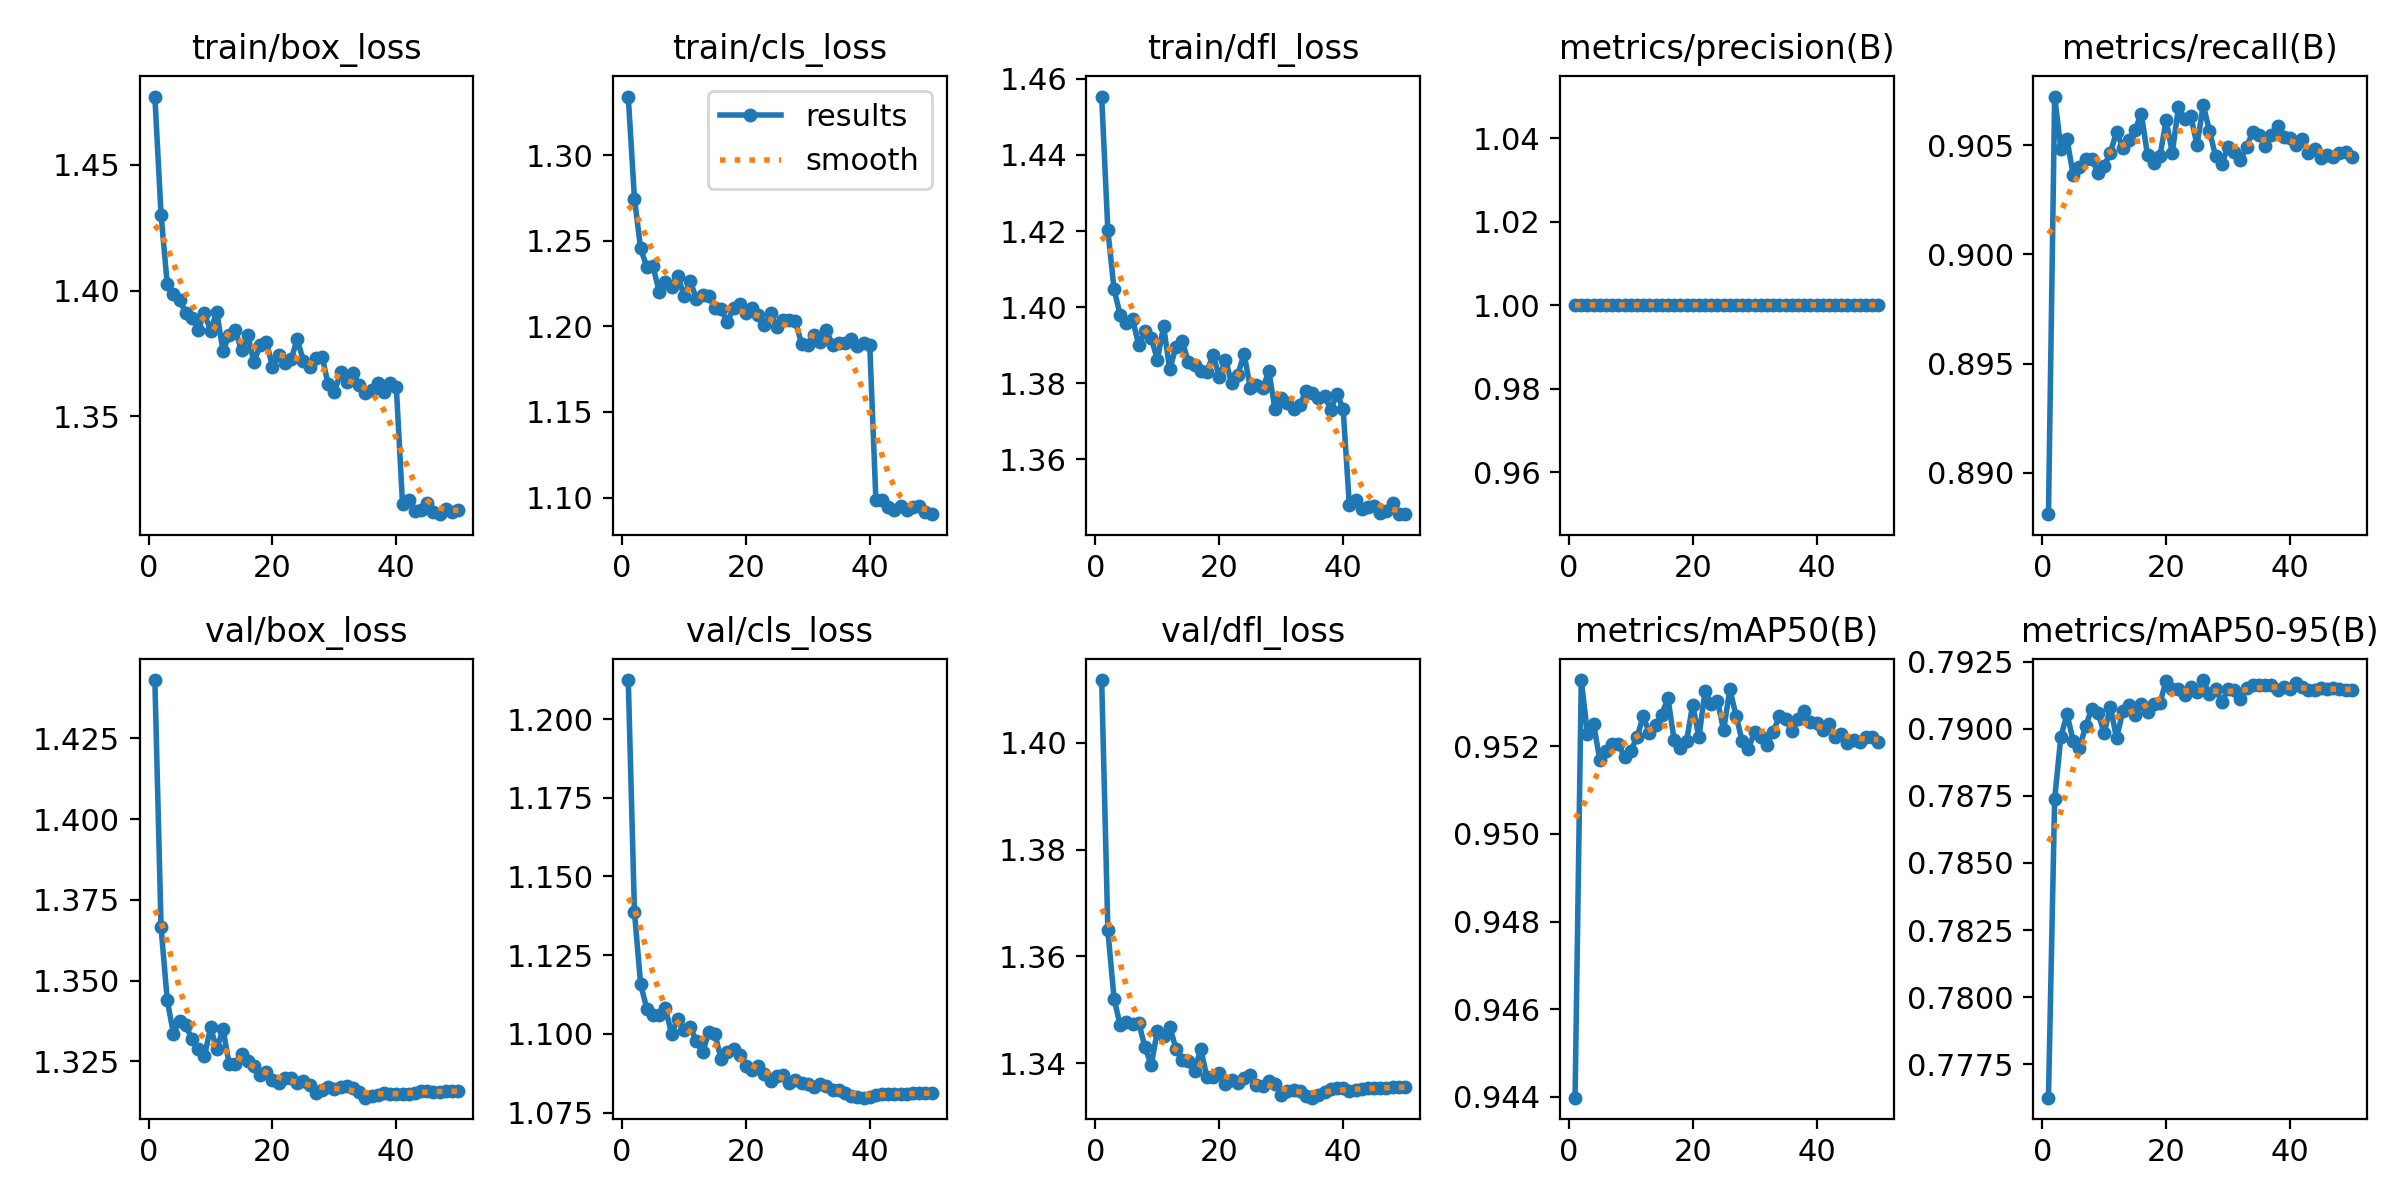


Confusion Matrix:


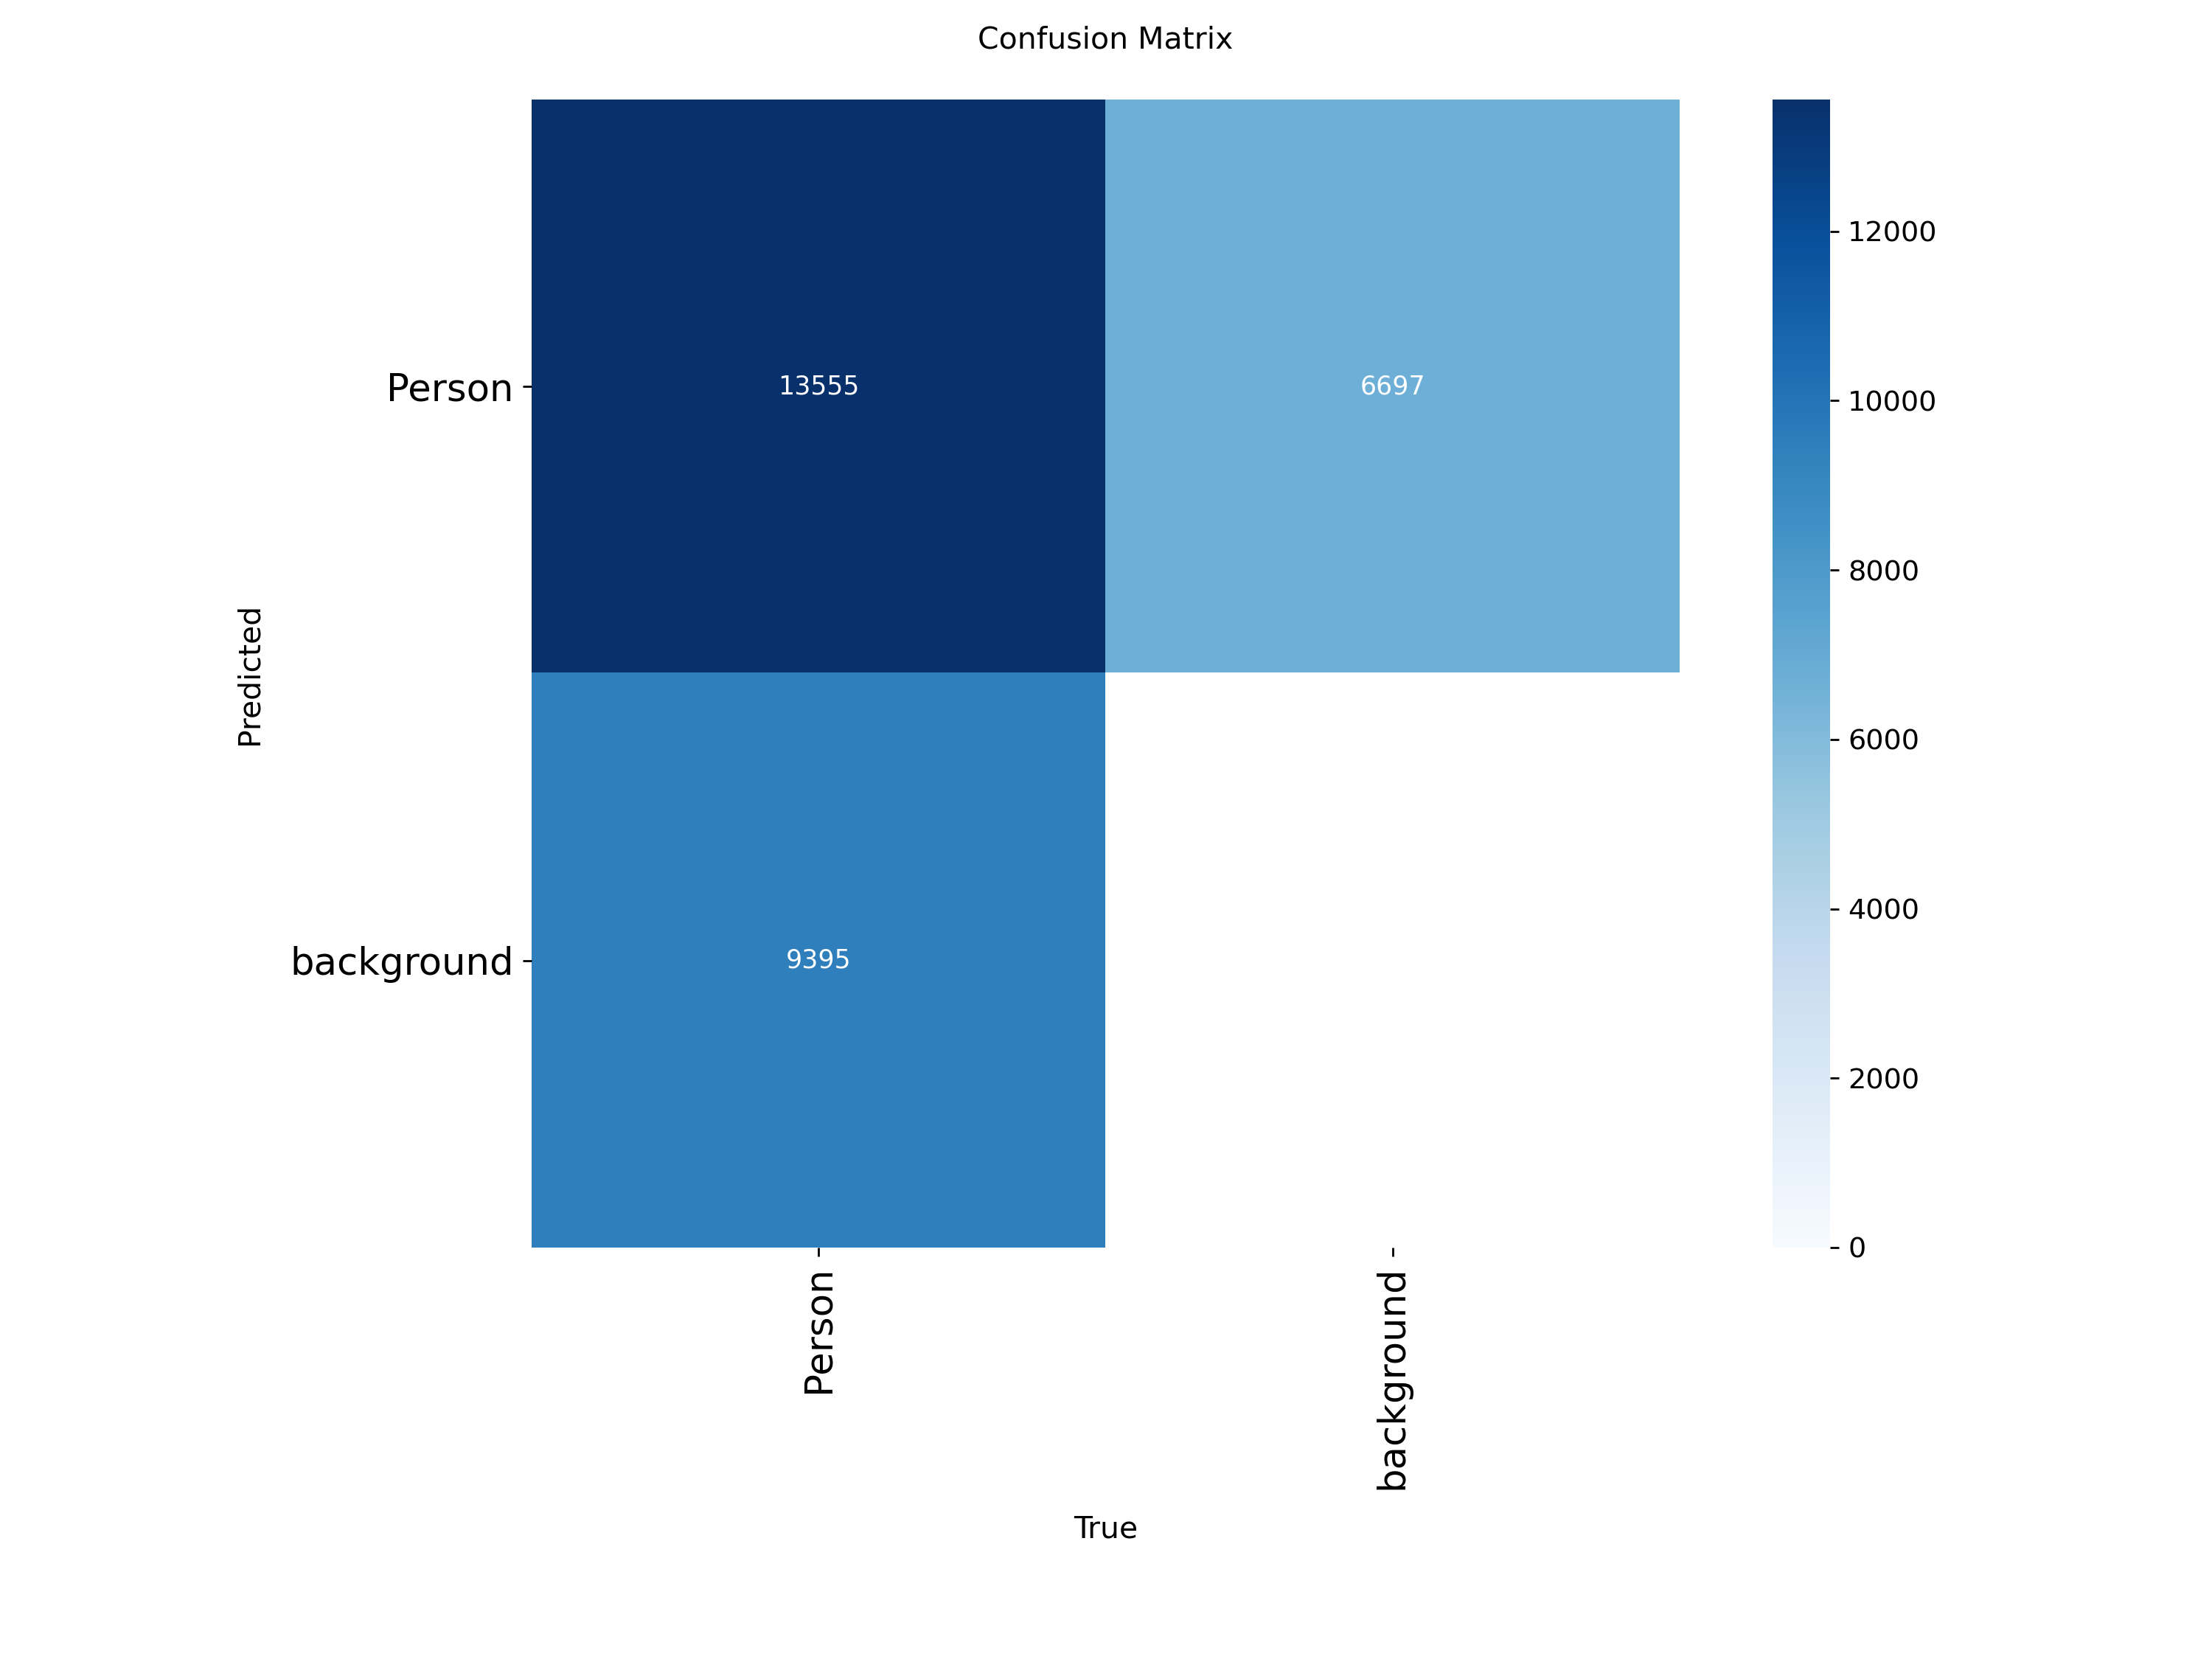

In [13]:
# Get the results directory
rresults_dir = Path(f'{rproject_name}/{rexperiment_name}')

print(f"Results saved to: {rresults_dir}")

# Display training curves
rresults_img = rresults_dir / 'results.png'
if rresults_img.exists():
    print("\nTraining Results:")
    display(Image(filename=str(rresults_img)))
else:
    print("Results image not found")

# Display confusion matrix
rconfusion_matrix = rresults_dir / 'confusion_matrix.png'
if rconfusion_matrix.exists():
    print("\nConfusion Matrix:")
    display(Image(filename=str(rconfusion_matrix)))